In [1]:
import numpy as np
import time
import pandas as pd
import random
import sys, getopt
import uproot
from scipy.interpolate import interp1d
from sklearn.metrics import auc
import numericalunits as nu
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from Functions import *

def get_TotalTime_days(a):
    No_of_particle= a['NoOfParticleSimulated'][0]

    Particle_per_second=175
    TotalTime= No_of_particle/Particle_per_second
    return TotalTime*nu.s/nu.hour

def get_TotalTime_seconds(a):
    No_of_particle= a['NoOfParticleSimulated'][0]
    Particle_per_second=175
    TotalTime= No_of_particle/Particle_per_second
    return TotalTime

In [2]:
Singlet= pd.read_table("Singlet.csv", sep=",", usecols=['Energy', 'Partition'])
Triplet = pd.read_table("Triplet.csv", sep=",", usecols=['Energy', 'Partition'])
QP = pd.read_table("QP.csv", sep=",", usecols=['Energy', 'Partition'])
Infrared = pd.read_table("Infrared.csv", sep=",", usecols=['Energy', 'Partition'])



Energy = np.linspace(0, 10, num=100000)
#f is singlet, g is triplet as the paper had it reversed

g = interp1d(Singlet["Energy"]/1000, Singlet["Partition"],fill_value=(0,  Singlet["Partition"][ len( Singlet["Partition"])-1] ), bounds_error=False)
SingletPartition= g(Energy)

f = interp1d(Triplet["Energy"]/1000, Triplet["Partition"],fill_value=(0, Triplet["Partition"][ len( Triplet["Partition"])-1]), bounds_error=False)
TripletPartition= f(Energy)

h = interp1d(QP["Energy"]/1000, QP["Partition"],fill_value=(0, QP["Partition"][ len( QP["Partition"])-1] ), bounds_error=False)
QPPartition = h(Energy)

IR = interp1d(Infrared["Energy"]/1000, Infrared["Partition"],fill_value=(0, QP["Partition"][ len( QP["Partition"])-1] ), bounds_error=False)
QPPartition = IR(Energy)


In [3]:
#for 2mm
#Radius_CPD= 38
#Radius_Helium= 30
#Midpoint= -11.645 
#Height_CPD=19.2-Midpoint
#half_height_Helium=2.0
#tree =uproot.open("ProcessedFiles/Run30/4mm/Combined4mm_ForHeSim.root")


#for 6mm
#Radius_CPD= 38
#Radius_Helium= 30
#Midpoint= -7.645
#Height_CPD=19.2-Midpoint
#half_height_Helium=6.0
#tree =uproot.open("ProcessedFiles/Run30/12mm/Combined12mm_ForHeSim.root")


#for 27.5mm
Radius_CPD= 38
Radius_Helium= 30
Midpoint= 0.11
Height_CPD=19.2-Midpoint
half_height_Helium=13.75
tree =uproot.open("ProcessedFiles/Run30/27point5mm/Combined27point5mm_ForHeSim.root")


tree3=tree["Event"]
arr3 = tree3.arrays(tree3.keys())
df_uproot3 = pd.DataFrame(arr3)

t =tree["Information"]
a = t.arrays(t.keys())
TotalTime_days= get_TotalTime_days(a)
TotalTime_seconds=get_TotalTime_seconds(a)


##Select only Helium things
Helium= pd.DataFrame(({b'TotalE_CPD': np.asarray(tree3['E_He_electron']), \
                       b'X_He_electron': np.asarray(tree3['X_He_electron']), \
                       b'Y_He_electron': np.asarray(tree3['Y_He_electron']), \
                       b'Z_He_electron': np.asarray(tree3['Z_He_electron']), \
                       b'TotalE_He': np.asarray(tree3['TotalE_He']), \
                       b'TotalE_CPD': np.asarray(tree3['TotalE_CPD']) }) )

#Total Energy Deposited 
Helium['Total_E'] = Helium[b'TotalE_He'] +Helium[b'TotalE_CPD'] 

#Remove Events where non He things happened 
Helium= Helium[ (Helium[b'TotalE_He']!=0) ]

#Select onlt the Iron Peak 5.8 keV and 7.5 keV 
Helium= Helium[ (Helium[b'TotalE_He']>=5.8) ]
Helium= Helium[ (Helium[b'TotalE_He']<=7.5) ]



#we need to make the origin of Helium as Origin
Helium[b'Z_He_electron']=Helium[b'Z_He_electron']-Midpoint

Helium[b'Radius']=np.sqrt(Helium[b'X_He_electron']**2+Helium[b'Y_He_electron']**2)

#Helium= Helium[ (Helium[b'Z_He_electron']>=13.6) ]
#Helium= Helium[ (Helium[b'Radius']>=27.0) ]


##energy partition
singlet_fraction,singlet_photon_mean,\
IR_fraction, IR_photon_mean,quasiparticle_fraction,triplet_photon_mean =Energy_partion(np.asarray( Helium[b'TotalE_He'] ),f,g,IR)

Helium['quasiparticle_E(eV)'] = quasiparticle_fraction*Helium[b'TotalE_He']*nu.keV/nu.eV

#Helium['geometric_efficency'] = get_frac_energy(np.asarray( Helium[b'X_He_electron'] )
#                                                        ,np.asarray( Helium[b'Y_He_electron'] )
#                                                        ,np.asarray( Helium[b'Z_He_electron'] )
#                                                        ,np.zeros( Helium.shape[0] )
#                                                        ,np.zeros( Helium.shape[0]  )
#                                                        ,Height_CPD*np.ones( Helium.shape[0]  ))


#Helium['singlet_E(eV)'] = singlet_fraction*Helium['geometric_efficency'] *Helium[b'TotalE_He']*nu.keV/nu.eV
Helium['singlet_photon_mean'] = singlet_photon_mean
Helium['triplet_photon_mean'] = triplet_photon_mean
Helium['IR_photon_mean'] = IR_photon_mean








In [4]:
#Let's do soem selection cuts for the parts that we wanna look into

#Near z=0
Helium= Helium[ (Helium[b'Z_He_electron']> -0.5)]
Helium= Helium[ (Helium[b'Z_He_electron'] < 0.5) ] 
# r<2.0 
Helium= Helium[ ( Helium[b'X_He_electron']**2 + Helium[b'Y_He_electron']**2 < 2*2 ) ] 


In [5]:
#reset the index
Helium.reset_index(inplace=True)
Helium

,index,b'TotalE_CPD',b'X_He_electron',b'Y_He_electron',b'Z_He_electron',b'TotalE_He',Total_E,b'Radius',quasiparticle_E(eV),singlet_photon_mean,triplet_photon_mean,IR_photon_mean
0,46,0.0,0.400094,1.476376,0.178733,5.86658,5.86658,1.529628,2423.48,121.0,74.0,3231.0
1,1904,0.0,-0.159030,1.326683,-0.486566,5.86658,5.86658,1.336181,1629.48,132.0,112.0,3331.0
2,3306,0.0,1.483189,0.150452,-0.366659,5.86658,5.86658,1.490800,2307.58,126.0,76.0,3270.0
3,3817,0.0,0.965929,-0.538382,0.328184,5.86658,5.86658,1.105836,2451.68,120.0,73.0,3269.0
4,5634,0.0,-0.963893,0.307444,0.022350,5.86658,5.86658,1.011737,2134.18,118.0,95.0,3244.0
...,...,...,...,...,...,...,...,...,...,...,...,...
394,696049,0.0,-1.156794,1.144673,0.195031,6.46658,6.46658,1.627406,2444.58,130.0,99.0,3580.0
395,697027,0.0,-0.668510,1.730438,0.146255,5.86658,5.86658,1.855080,2147.08,125.0,87.0,3275.0
396,698258,0.0,1.326459,0.887743,-0.053499,5.86658,5.86658,1.596114,2583.68,108.0,77.0,3229.0
397,700511,0.0,1.334276,0.749373,-0.142315,5.86658,5.86658,1.530311,2396.38,122.0,74.0,3342.0


In [6]:
#We need to get the parameters for converison of momentum to energy and velocity 
omega_params  = Get_P("Dispersion_relation_He.csv")
domega_params  = Get_V("Momentum_Velocity_relation_He.csv")
#This momentum spacer is generated earlier and follow bose Einstien condenstation 
momentum_sampler=np.load("momentum_sampler.npy")


In [8]:
start_time = time.time()

Collected_Energy=np.zeros(Helium.shape[0])
Time_collection=np.zeros(Helium.shape[0])
Prompt_scintillation=np.zeros(Helium.shape[0])
Time_collection_mode=np.zeros(Helium.shape[0])
S2=np.zeros(Helium.shape[0])
X_ini=np.zeros(Helium.shape[0])
Y_ini=np.zeros(Helium.shape[0])
Z_ini=np.zeros(Helium.shape[0])
Pulse_trace=np.arange(0,1000,2)


# These are not being used because I sample momentum using momentum_sampler
#p= np.linspace(0.001, 4700, num=470000)#eV fine spacing
p= np.linspace(0, 4700, num=470)#keV  coarse spacing
Temp_QP=2 
functional_form=p**2*Boltzman_factor_without_V(p,Temp_QP,omega_params)
pdf=functional_form/np.sum(functional_form)
#normalisation= np.trapz(functional_form, p, p[1]-p[0]) 




#for i in range(Helium.shape[0]):
for i in range(10):

    if(i%1==0):
        print(i)
        
    #we get energy, momentum magnitude, velocity magnitude etc from geant
    #change the function_form, to change the intial QP populations distribution
    Energy,Momentum,Velocity,X1,Y1,Z1,Intial_X,Intial_Y,Intial_Z=Get_Energy_Velocity_Momentum_Position_df_from_recoil\
                                                       (Helium['quasiparticle_E(eV)'][i],\
                                                        Helium[b'X_He_electron'][i],\
                                                        Helium[b'Y_He_electron'][i],\
                                                        Helium[b'Z_He_electron'][i],\
                                                        p, pdf,omega_params,domega_params)
    
    

    
    
    #get random momentum vectors 
    u = np.random.uniform(low=0, high=1,size=np.size(X1))
    theta=2*np.pi*u
    phi= np.arccos(1-2*u)
    
    Vx_unit_vector=np.sin(phi)*np.cos(theta)
    Vy_unit_vector=np.sin(phi)*np.sin(theta)
    Vz_unit_vector=np.cos(phi)
    
    
    #unit_vector = np.random.uniform(low=-1, high=1,size=(3*np.size(X1))).reshape((np.size(X1), 3))
    #Vx_unit_vector=unit_vector.T[0]/np.linalg.norm(unit_vector, axis=1)
    #Vy_unit_vector=unit_vector.T[1]/np.linalg.norm(unit_vector, axis=1)
    #Vz_unit_vector=unit_vector.T[2]/np.linalg.norm(unit_vector, axis=1)
    
    
    #get the prompt energy, no reflection
    Prompt = Get_PromptEnergy_from_recoil_position( Helium['singlet_photon_mean'][i],\
                                                   Helium['IR_photon_mean'][i],\
                                               Intial_X, Intial_Y, Intial_Z, \
                                               Radius_Helium, Radius_CPD,Height_CPD)

    
    #remove the QP that aere moving downwards
    X,Y,Z,nx, ny, nz,Energy,Momentum,Velocity=Remove_the_downward_QP(Vx_unit_vector,Vy_unit_vector,\
                                                 Vz_unit_vector,  X1, Y1, Z1,\
                                                                          Energy,Momentum,Velocity)
    #get coordinate where the QP hit the He surface
    X_He,Y_He,Z_He,nx_He, ny_He, nz_He,Energy,Momentum,Velocity=get_Coordinate_He_Surface(X,Y,Z,nx, ny, nz,\
                                                                    Energy,Momentum,Velocity,half_height_Helium,Radius_Helium)


    theta_I = Get_Angle_of_incidence(nz_He)
    critical_Angle_of_incidence = Get_critical_Angle_of_incidence(Energy,Velocity)
    
    
   
    #Remove the QP that are not at a favourable angle for evaporation
    X_He_S,Y_He_S,Z_He_S,nx_He_S, ny_He_S, \
                     nz_He_S,Energy,Momentum,Velocity,theta_I_He_S=\
                         Remove_bad_incident_QP(X_He,Y_He,Z_He,nx_He,\
                                                ny_He, nz_He,Energy,Momentum,Velocity,theta_I,critical_Angle_of_incidence)

    # after Quantumn evaporation, you need to chnage the momentum direction
    nx_V,ny_V,nz_V,X_He_S,Y_He_S,Z_He_S,Energy,Velocity,Momentum=\
                                  change_direction(nx_He_S,ny_He_S,nz_He_S,\
                                          X_He_S,Y_He_S,Z_He_S,theta_I_He_S,Energy,Velocity,Momentum)

    # get coordinate where the QP hit the CPD surface
    X_CPD,Y_CPD,Z_CPD,X_He_S,Y_He_S,Z_He_S\
                ,Energy,Momentum,Velocity,Velocity_atom = get_Coordinate_CPD_Surface(X_He_S\
                                 ,Y_He_S,Z_He_S,nx_V,ny_V,nz_V,\
                                     Energy,Momentum,Velocity, Height_CPD,Radius_Helium,Radius_CPD)

    # Calculate the Time it takes for each QP hititng the CPD surface
    Energy_final,total_time_microseconds,position_intx,\
                    position_inty, position_intz=get_Time_QP(X_He_S,Y_He_S,Z_He_S,X_CPD,Y_CPD,Z_CPD,Velocity,\
                                                 Velocity_atom,Energy,Momentum,Intial_X,Intial_Y,Intial_Z)
    
    #plt.hist( Momentum, bins=np.arange(0,4700,1),histtype='stepfilled', alpha=0.3, color='red',label="Prompt Scintillation Model", density=True)
    #plt.scatter(total_time_microseconds,Velocity)
    #plt.show()
    
    Collected_Energy[i]=9*nu.meV/nu.eV*np.size(Energy_final)
    Time_collection[i]=total_time_microseconds.mean()
    Prompt_scintillation[i]=Prompt
    n,bins=np.histogram(total_time_microseconds, bins=np.arange(0,1002,2))
    Time_collection_mode[i]= bins[np.argmax(n)]
    S2[i]=auc( 0.5*(bins[1:] + bins[:-1]), n)
    Pulse_trace=np.vstack((Pulse_trace,n))
    X_ini[i]=position_intx
    Y_ini[i]=position_inty
    Z_ini[i]=position_intz
    
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
--- 21.82014298439026 seconds ---


In [17]:
#For saving 
#np.save("For_Doug/NoReflection_auc/z_equalto_zero_r_lessthan_1_auc",S2)
#np.save("For_Doug/NoReflection_auc/z_equalto_zero_r_lessthan_1_Time_collection_mode",Time_collection_mode)
#np.save("For_Doug/NoReflection_auc/z_equalto_zero_r_lessthan_1_100_pulse",Pulse_trace)

(0.0, 7990.0)

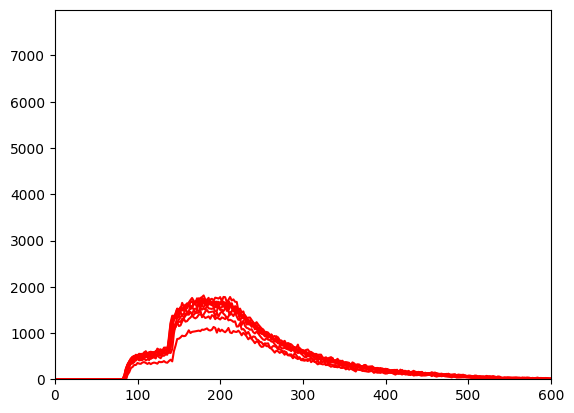

In [9]:
#E=np.load("For_Doug/NoReflection_auc/z_greaterthan_12_r_lessthan_2_100_pulse.npy")
E=Pulse_trace

#average
#x,y=get_timeStamp_AmplitudeMean_Sim(E)

for pulse_number in range (10):
    #print(np.argmax(E[1:][pulse_number])-20)
    plt.plot( E[0],\
        E[1:][pulse_number], c='red')
#plt.plot(x,y, c="k")
plt.xlim(0,600)
plt.ylim(0,7990)
